# Makine Öğrenmesi ile Maaş Tahmini

## İş Problemi
Maaş bilgileri ve 1986 yılına ait kariyer istatistikleri paylaşılan beyzbol oyuncularının maaş tahminleri için bir makine öğrenmesi modeli geliştiriniz.

## Veri Seti Hikayesi
Bu veri seti orijinal olarak Carnegie Mellon Üniversitesi'nde bulunan
StatLib kütüphanesinden alınmıştır. Veri seti 1988 ASA Grafik Bölümü
Poster Oturumu'nda kullanılan verilerin bir parçasıdır. Maaş verileri
orijinal olarak Sports Illustrated, 20 Nisan 1987'den alınmıştır. 1986 ve
kariyer istatistikleri, Collier Books, Macmillan Publishing Company,
New York tarafından yayınlanan 1987 Beyzbol Ansiklopedisi
Güncellemesinden elde edilmiştir.

## Değişkenler
- AtBat 1986-1987 sezonunda bir beyzbol sopası ile topa yapılan vuruş sayısı
- Hits 1986-1987 sezonundaki isabet sayısı
- HmRun 1986-1987 sezonundaki en değerli vuruş sayısı
- Runs 1986-1987 sezonunda takımına kazandırdığı sayı
- RBI Bir vurucunun vuruş yaptıgında koşu yaptırdığı oyuncu sayısı
- Walks Karşı oyuncuya yaptırılan hata sayısı
- Years Oyuncunun major liginde oynama süresi (sene)
- CAtBat Oyuncunun kariyeri boyunca topa vurma sayısı
- CHits Oyuncunun kariyeri boyunca yaptığı isabetli vuruş sayısı
- CHmRun Oyucunun kariyeri boyunca yaptığı en değerli sayısı
- CRuns Oyuncunun kariyeri boyunca takımına kazandırdığı sayı
- CRBI Oyuncunun kariyeri boyunca koşu yaptırdırdığı oyuncu sayısı
- CWalks Oyuncun kariyeri boyunca karşı oyuncuya yaptırdığı hata sayısı
- League Oyuncunun sezon sonuna kadar oynadığı ligi gösteren A ve N seviyelerine sahip bir faktör
- Division 1986 sonunda oyuncunun oynadığı pozisyonu gösteren E ve W seviyelerine sahip bir faktör
- PutOuts Oyun icinde takım arkadaşınla yardımlaşma
- Assits 1986-1987 sezonunda oyuncunun yaptığı asist sayısı
- Errors 1986-1987 sezonundaki oyuncunun hata sayısı
- Salary Oyuncunun 1986-1987 sezonunda aldığı maaş(bin uzerinden)
- NewLeague 1987 sezonunun başında oyuncunun ligini gösteren A ve N seviyelerine sahip bir faktör

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import LocalOutlierFactor
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
import warnings
warnings.simplefilter(action="ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df = pd.read_csv("datasets/hitters.csv")
df.head()


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.00,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.00,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.00,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.50,N


# Genel Resim

In [3]:
def checkDf(dataframe, head = 8):
  print("##### Shape #####")
  print(dataframe.shape)
  print("\n##### Types #####")
  print(dataframe.dtypes)
  print("\n##### Tail #####")
  print(dataframe.tail(head))
  print("\n##### Head #####")
  print(dataframe.head(head))
  print("\n##### Null Analysis #####")
  print(dataframe.isnull().sum())
  print("\n##### Quantiles #####")
  print(dataframe.describe([0,0.05, 0.50, 0.95, 0.99, 1]).T)  
checkDf(df)

##### Shape #####
(322, 20)

##### Types #####
AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League        object
Division      object
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague     object
dtype: object

##### Tail #####
     AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary NewLeague
314    408   117     11    66   41     34      1     408    117      11     66    41      34      N        W      942       72      11  120.00         N
315    593   172     22    82  100     57      1     593    172      22     82   100      57      A        W     1222      139      15  165.00         A
316    221    53      2    21   23     22 

# Numerik ve Kategorik Değişkenlerin Yakalanması

In [4]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """


    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)


Observations: 322
Variables: 20
cat_cols: 3
num_cols: 17
cat_but_car: 0
num_but_cat: 0


# Numerik ve Kategorik Değişkenlerin Analizi

        League  Ratio
League               
A          175  54.35
N          147  45.65
##########################################


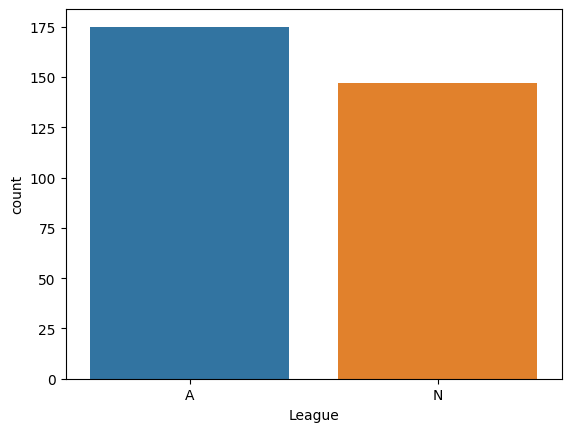

          Division  Ratio
Division                 
W              165  51.24
E              157  48.76
##########################################


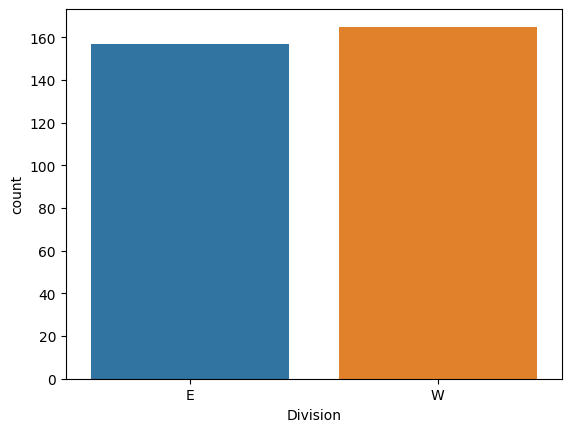

           NewLeague  Ratio
NewLeague                  
A                176  54.66
N                146  45.34
##########################################


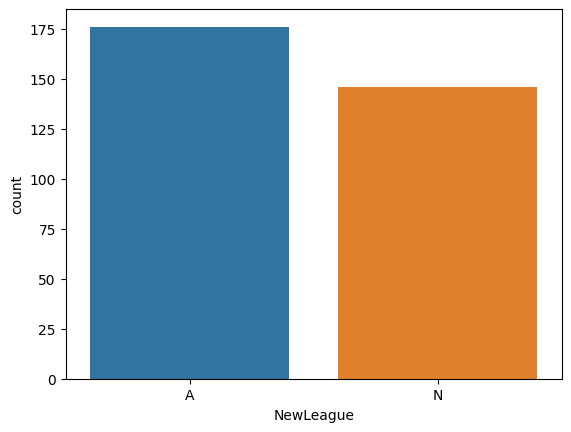

In [5]:
def cat_summary(dataframe, col_name, plot=False):

    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

for col in cat_cols:
    cat_summary(df, col, plot=True)

count   322.00
mean    380.93
std     153.40
min      16.00
5%      161.00
10%     194.10
20%     221.80
30%     281.30
40%     321.80
50%     379.50
60%     430.20
70%     490.00
80%     535.60
90%     584.90
95%     609.90
99%     658.59
max     687.00
Name: AtBat, dtype: float64


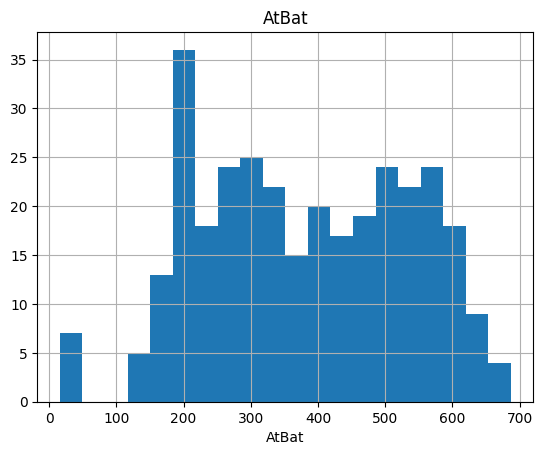

count   322.00
mean    101.02
std      46.45
min       1.00
5%       39.00
10%      45.10
20%      57.00
30%      70.00
40%      82.00
50%      96.00
60%     113.00
70%     128.70
80%     144.00
90%     163.00
95%     174.00
99%     210.79
max     238.00
Name: Hits, dtype: float64


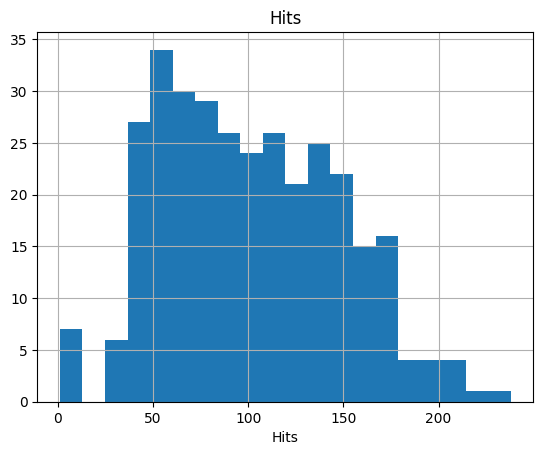

count   322.00
mean     10.77
std       8.71
min       0.00
5%        0.00
10%       1.00
20%       3.00
30%       5.00
40%       6.00
50%       8.00
60%      10.60
70%      14.00
80%      18.00
90%      24.00
95%      28.95
99%      33.00
max      40.00
Name: HmRun, dtype: float64


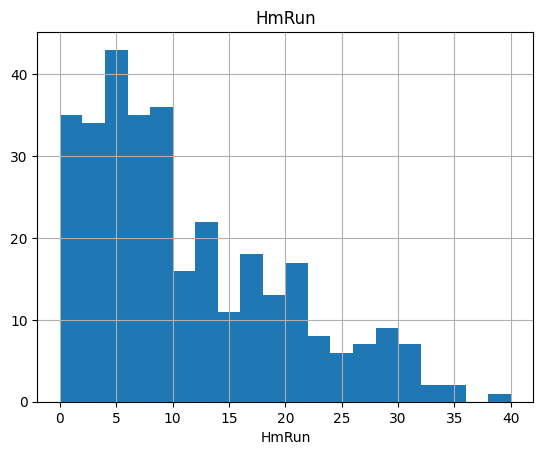

count   322.00
mean     50.91
std      26.02
min       0.00
5%       17.00
10%      20.10
20%      27.00
30%      33.00
40%      41.00
50%      48.00
60%      55.60
70%      66.00
80%      75.80
90%      89.00
95%      94.00
99%     107.79
max     130.00
Name: Runs, dtype: float64


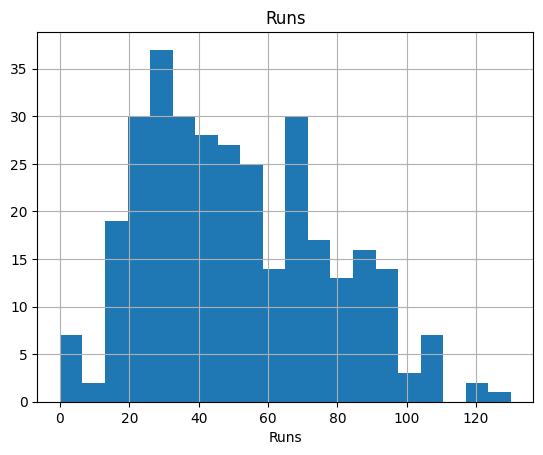

count   322.00
mean     48.03
std      26.17
min       0.00
5%       14.00
10%      19.00
20%      26.00
30%      30.00
40%      36.40
50%      44.00
60%      49.00
70%      58.00
80%      73.00
90%      86.00
95%      96.00
99%     112.37
max     121.00
Name: RBI, dtype: float64


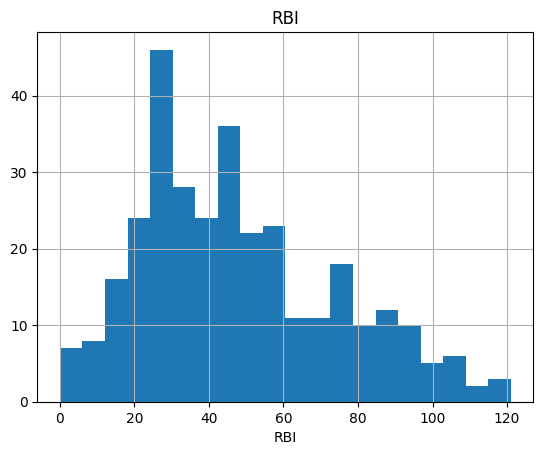

count   322.00
mean     38.74
std      21.64
min       0.00
5%       11.05
10%      15.00
20%      20.00
30%      24.00
40%      30.00
50%      35.00
60%      40.00
70%      48.70
80%      59.00
90%      69.90
95%      78.00
99%      93.58
max     105.00
Name: Walks, dtype: float64


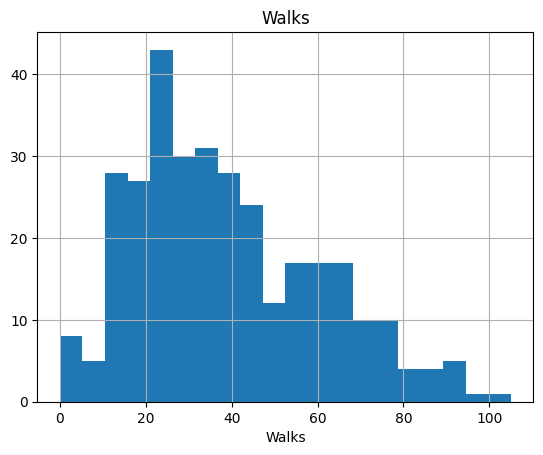

count   322.00
mean      7.44
std       4.93
min       1.00
5%        1.00
10%       2.00
20%       3.00
30%       4.00
40%       5.00
50%       6.00
60%       7.60
70%      10.00
80%      12.00
90%      15.00
95%      17.00
99%      19.79
max      24.00
Name: Years, dtype: float64


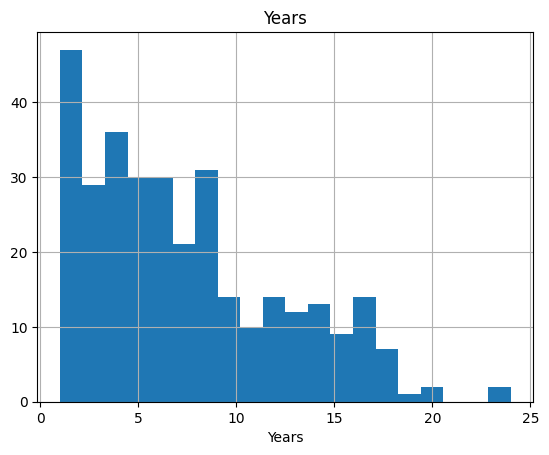

count     322.00
mean     2648.68
std      2324.21
min        19.00
5%        216.50
10%       342.20
20%       667.60
30%       963.40
40%      1402.20
50%      1928.00
60%      2654.00
70%      3365.00
80%      4483.00
90%      6123.40
95%      7125.60
99%      8749.97
max     14053.00
Name: CAtBat, dtype: float64


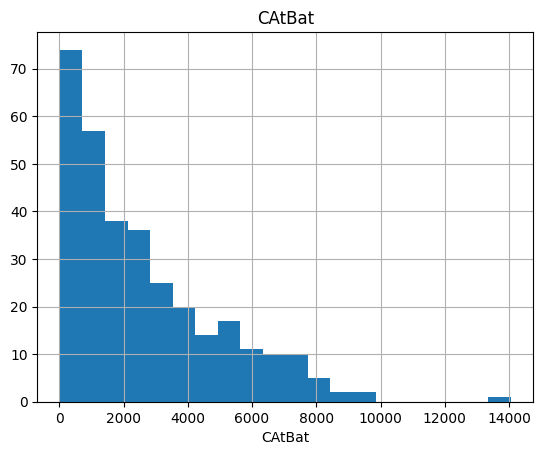

count    322.00
mean     717.57
std      654.47
min        4.00
5%        54.00
10%       86.00
20%      164.60
30%      238.00
40%      355.80
50%      508.00
60%      708.20
70%      911.10
80%     1229.20
90%     1659.60
95%     2017.15
99%     2500.34
max     4256.00
Name: CHits, dtype: float64


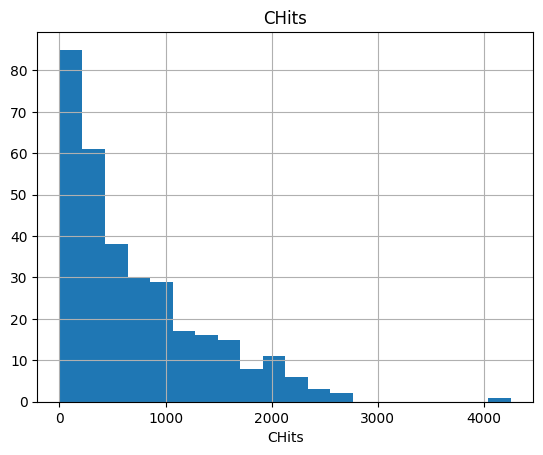

count   322.00
mean     69.49
std      86.27
min       0.00
5%        2.00
10%       4.00
20%      10.20
30%      16.30
40%      27.40
50%      37.50
60%      51.20
70%      72.40
80%     103.80
90%     194.90
95%     265.65
99%     373.12
max     548.00
Name: CHmRun, dtype: float64


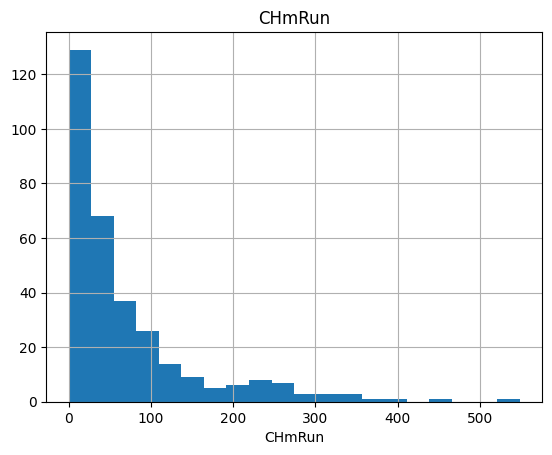

count    322.00
mean     358.80
std      334.11
min        1.00
5%        27.00
10%       38.10
20%       80.40
30%      117.30
40%      181.00
50%      247.00
60%      333.00
70%      443.40
80%      627.20
90%      895.70
95%     1032.30
99%     1174.37
max     2165.00
Name: CRuns, dtype: float64


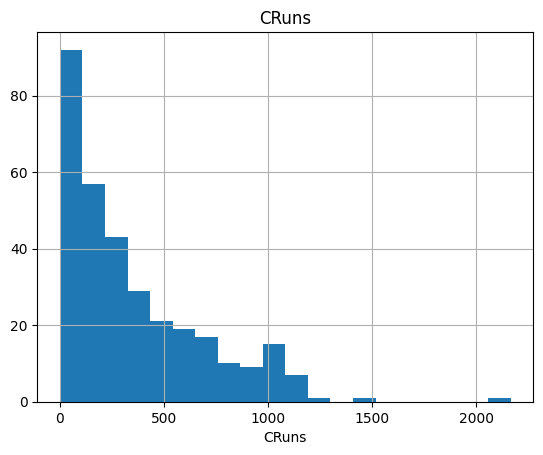

count    322.00
mean     330.12
std      333.22
min        0.00
5%        22.05
10%       34.10
20%       70.20
30%      106.30
40%      149.00
50%      220.50
60%      303.60
70%      379.10
80%      496.20
90%      861.60
95%     1071.75
99%     1310.85
max     1659.00
Name: CRBI, dtype: float64


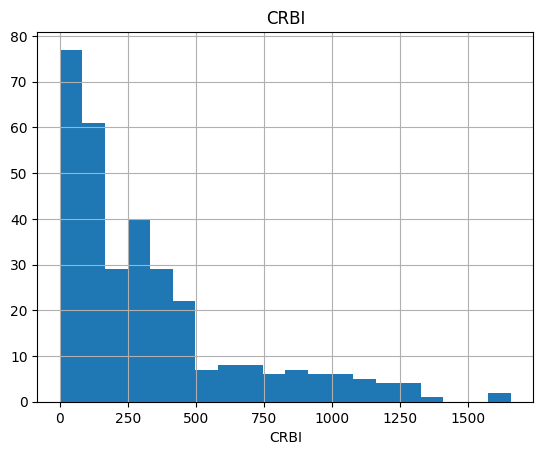

count    322.00
mean     260.24
std      267.06
min        0.00
5%        15.05
10%       30.10
20%       55.00
30%       82.00
40%      117.40
50%      170.50
60%      226.60
70%      300.70
80%      421.00
90%      643.90
95%      817.60
99%     1139.14
max     1566.00
Name: CWalks, dtype: float64


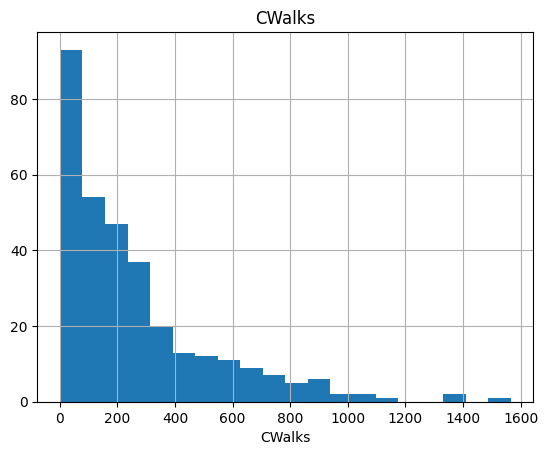

count    322.00
mean     288.94
std      280.70
min        0.00
5%        33.20
10%       62.20
20%       99.60
30%      132.00
40%      167.00
50%      212.00
60%      257.40
70%      303.00
80%      365.80
90%      685.60
95%      910.65
99%     1301.19
max     1378.00
Name: PutOuts, dtype: float64


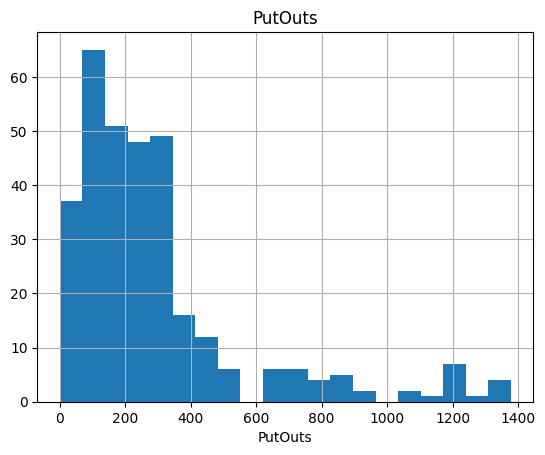

count   322.00
mean    106.91
std     136.85
min       0.00
5%        0.00
10%       2.00
20%       5.20
30%       9.00
40%      15.40
50%      39.50
60%      76.80
70%     134.80
80%     210.80
90%     353.30
95%     431.45
99%     478.16
max     492.00
Name: Assists, dtype: float64


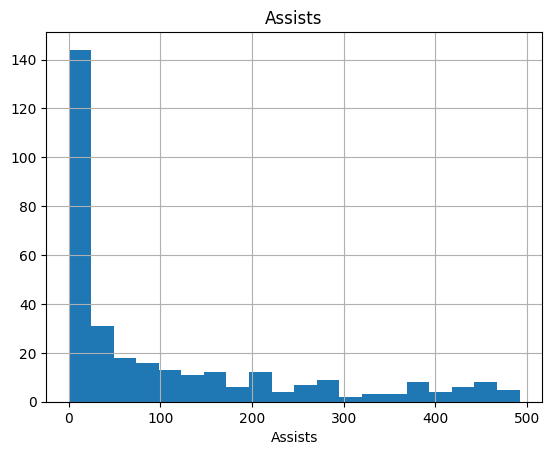

count   322.00
mean      8.04
std       6.37
min       0.00
5%        0.00
10%       1.00
20%       3.00
30%       4.00
40%       5.00
50%       6.00
60%       8.00
70%      10.00
80%      13.00
90%      17.00
95%      20.00
99%      25.79
max      32.00
Name: Errors, dtype: float64


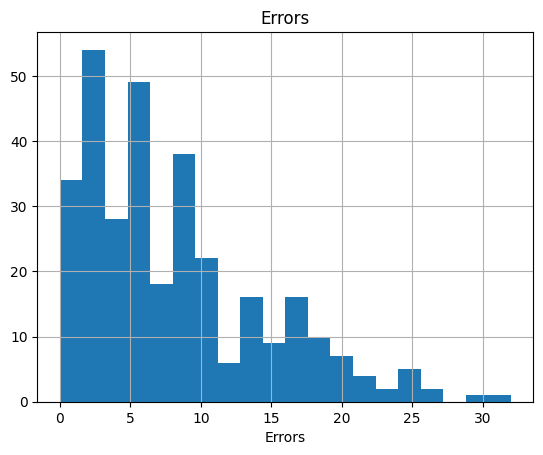

count    263.00
mean     535.93
std      451.12
min       67.50
5%        86.60
10%      100.00
20%      155.00
30%      221.00
40%      300.00
50%      425.00
60%      538.00
70%      700.00
80%      809.00
90%     1048.67
95%     1346.00
99%     2032.89
max     2460.00
Name: Salary, dtype: float64


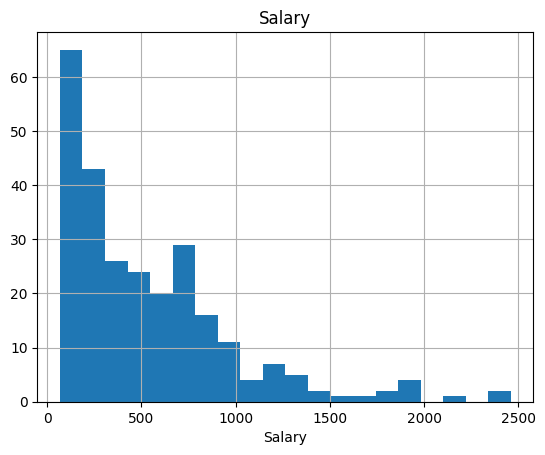

In [6]:
def num_summary(dataframe, numerical_col, plot=False):

    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]

    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

for col in num_cols:
    num_summary(df, col, plot=True)


# Hedef Değişken Analizi

In [7]:
def target_summary_with_cat(dataframe, target, categorical_col):

    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df, "Salary", col)

        TARGET_MEAN
League             
A            542.00
N            529.12


          TARGET_MEAN
Division             
E              624.27
W              450.88


           TARGET_MEAN
NewLeague             
A               537.11
N               534.55




In [11]:
def targetSummaryWithCat(dataframe, target, numCol):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(numCol)[target].mean()}), end="\n\n\n")
for col in catCols:
    targetSummaryWithCat(df, "Salary", col)

        TARGET_MEAN
League             
A            542.00
N            529.12


          TARGET_MEAN
Division             
E              624.27
W              450.88


           TARGET_MEAN
NewLeague             
A               537.11
N               534.55




# Korelasyon Analizi

In [12]:
df.corr()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
AtBat,1.00,0.97,0.59,0.91,0.82,0.67,0.05,0.24,0.25,0.24,0.27,0.24,0.17,0.32,0.35,0.35,0.39
Hits,0.97,1.00,0.56,0.92,0.81,0.64,0.04,0.23,0.26,0.20,0.26,0.23,0.15,0.31,0.32,0.31,0.44
HmRun,0.59,0.56,1.00,0.65,0.86,0.48,0.12,0.22,0.22,0.49,0.26,0.35,0.23,0.28,-0.11,0.04,0.34
Runs,0.91,0.92,0.65,1.00,0.80,0.73,0.00,0.19,0.20,0.23,0.25,0.21,0.18,0.28,0.22,0.24,0.42
RBI,0.82,0.81,0.86,0.80,1.00,0.62,0.15,0.29,0.31,0.44,0.32,0.39,0.25,0.34,0.11,0.19,0.45
Walks,0.67,0.64,0.48,0.73,0.62,1.00,0.14,0.28,0.28,0.33,0.34,0.31,0.42,0.30,0.15,0.13,0.44
Years,0.05,0.04,0.12,0.00,0.15,0.14,1.00,0.92,0.90,0.73,0.88,0.87,0.84,-0.00,-0.08,-0.16,0.40
CAtBat,0.24,0.23,0.22,0.19,0.29,0.28,0.92,1.00,1.00,0.80,0.98,0.95,0.91,0.06,0.00,-0.07,0.53
CHits,0.25,0.26,0.22,0.20,0.31,0.28,0.90,1.00,1.00,0.78,0.98,0.95,0.89,0.08,-0.00,-0.06,0.55
CHmRun,0.24,0.20,0.49,0.23,0.44,0.33,0.73,0.80,0.78,1.00,0.82,0.93,0.80,0.11,-0.16,-0.14,0.52


In [10]:
def highCorrelatedCols(dataframe,plot=False,corrTh=0.90):
    corr=dataframe.corr()
    corrMatrix=corr.abs()
    upperTriangleMatrix = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k=1).astype(np.bool))
    dropList = [col for col in upperTriangleMatrix.columns if any(upperTriangleMatrix[col] > 0.90)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={"figure.figsize": (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return dropList



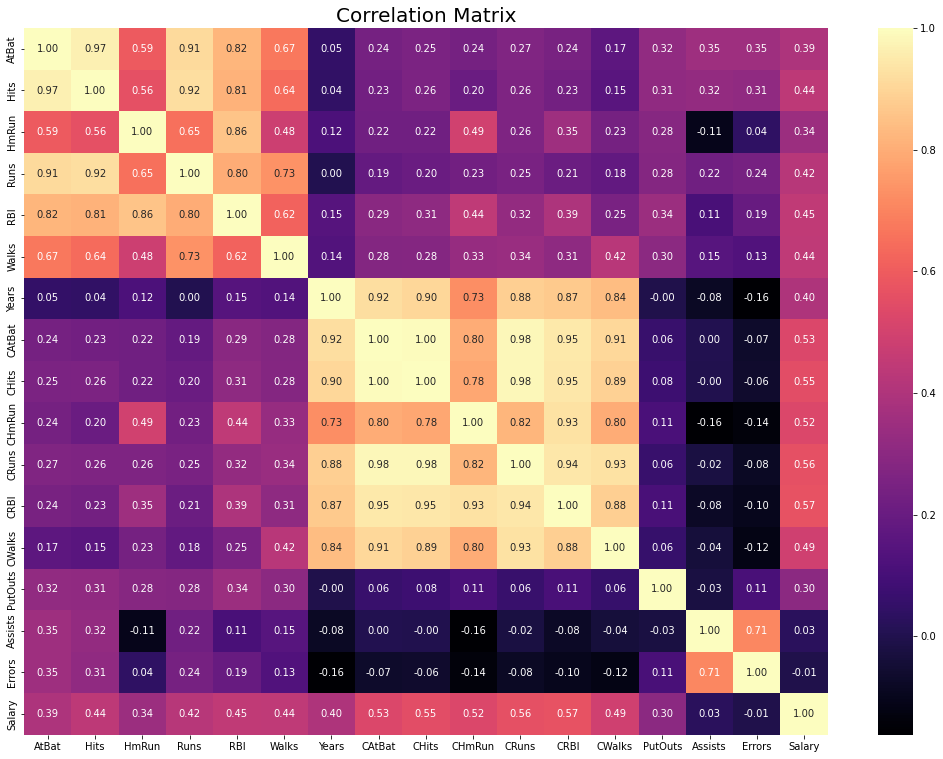

In [14]:
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df[numCols].corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

# Aykırı Gözlemlerin Analizi

In [12]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
    print(col, check_outlier(df, col))

for col in num_cols:
    if check_outlier(df, col):
        replace_with_thresholds(df, col)


AtBat False
Hits False
HmRun True
Runs True
RBI True
Walks True
Years True
CAtBat True
CHits True
CHmRun True
CRuns True
CRBI True
CWalks True
PutOuts True
Assists True
Errors True
Salary True


In [13]:
df.isnull().any()

AtBat        False
Hits         False
HmRun        False
Runs         False
RBI          False
Walks        False
Years        False
CAtBat       False
CHits        False
CHmRun       False
CRuns        False
CRBI         False
CWalks       False
League       False
Division     False
PutOuts      False
Assists      False
Errors       False
Salary        True
NewLeague    False
dtype: bool

# 2. Missing Values (Eksik Değerler)

In [14]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

missing_values_table(df)

        n_miss  ratio
Salary      59  18.32


In [15]:
df.dropna(inplace=True)


# 3. Feature Extraction (Özellik Çıkarımı)


In [16]:
new_num_cols=[col for col in num_cols if col!="Salary"]

df[new_num_cols]=df[new_num_cols]+0.0000000001

df['NEW_Hits'] = df['Hits'] / df['CHits'] + df['Hits']
df['NEW_RBI'] = df['RBI'] / df['CRBI']
df['NEW_Walks'] = df['Walks'] / df['CWalks']
df['NEW_PutOuts'] = df['PutOuts'] * df['Years']
df["Hits_Success"] = (df["Hits"] / df["AtBat"]) * 100
df["NEW_CRBI*CATBAT"] = df['CRBI'] * df['CAtBat']
df["NEW_RBI"] = df["RBI"] / df["CRBI"]
df["NEW_Chits"] = df["CHits"] / df["Years"]
df["NEW_CHmRun"] = df["CHmRun"] * df["Years"]
df["NEW_CRuns"] = df["CRuns"] / df["Years"]
df["NEW_Chits"] = df["CHits"] * df["Years"]
df["NEW_RW"] = df["RBI"] * df["Walks"]
df["NEW_RBWALK"] = df["RBI"] / df["Walks"]
df["NEW_CH_CB"] = df["CHits"] / df["CAtBat"]
df["NEW_CHm_CAT"] = df["CHmRun"] / df["CAtBat"]
df['NEW_Diff_Atbat'] = df['AtBat'] - (df['CAtBat'] / df['Years'])
df['NEW_Diff_Hits'] = df['Hits'] - (df['CHits'] / df['Years'])
df['NEW_Diff_HmRun'] = df['HmRun'] - (df['CHmRun'] / df['Years'])
df['NEW_Diff_Runs'] = df['Runs'] - (df['CRuns'] / df['Years'])
df['NEW_Diff_RBI'] = df['RBI'] - (df['CRBI'] / df['Years'])
df['NEW_Diff_Walks'] = df['Walks'] - (df['CWalks'] / df['Years'])

# 4. One-Hot Encoding


In [17]:

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)
df.head()


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,NEW_Hits,NEW_RBI,NEW_Walks,NEW_PutOuts,Hits_Success,NEW_CRBI*CATBAT,NEW_Chits,NEW_CHmRun,NEW_CRuns,NEW_RW,NEW_RBWALK,NEW_CH_CB,NEW_CHm_CAT,NEW_Diff_Atbat,NEW_Diff_Hits,NEW_Diff_HmRun,NEW_Diff_Runs,NEW_Diff_RBI,NEW_Diff_Walks,League_N,Division_W,NewLeague_N
1,315.00,81.00,7.00,24.00,38.00,39.00,14.00,3449.00,835.00,69.00,321.00,414.00,375.00,632.00,43.00,10.00,475.00,81.10,0.09,0.10,8848.00,25.71,1427886.00,11690.00,966.00,22.93,1482.00,0.97,0.24,0.02,68.64,21.36,2.07,1.07,8.43,12.21,True,True,True
2,479.00,130.00,18.00,66.00,72.00,76.00,3.00,1624.00,457.00,63.00,224.00,266.00,263.00,648.63,82.00,14.00,480.00,130.28,0.27,0.29,1945.88,27.14,431984.00,1371.00,189.00,74.67,5472.00,0.95,0.28,0.04,-62.33,-22.33,-3.00,-8.67,-16.67,-11.67,False,True,False
3,496.00,141.00,20.00,65.00,78.00,37.00,11.00,5628.00,1575.00,204.00,828.00,838.00,354.00,200.00,11.00,3.00,500.00,141.09,0.09,0.10,2200.00,28.43,4716264.00,17325.00,2244.00,75.27,2886.00,2.11,0.28,0.04,-15.64,-2.18,1.45,-10.27,1.82,4.82,True,False,True
4,321.00,87.00,10.00,39.00,42.00,30.00,2.00,396.00,101.00,12.00,48.00,46.00,33.00,648.63,40.00,4.00,91.50,87.86,0.91,0.91,1297.25,27.10,18216.00,202.00,24.00,24.00,1260.00,1.40,0.26,0.03,123.00,36.50,4.00,15.00,19.00,13.50,True,False,True
5,594.00,169.00,4.00,74.00,51.00,35.00,11.00,4408.00,1133.00,19.00,501.00,336.00,194.00,282.00,404.50,23.00,750.00,169.15,0.15,0.18,3102.00,28.45,1481088.00,12463.00,209.00,45.55,1785.00,1.46,0.26,0.00,193.27,66.00,2.27,28.45,20.45,17.36,False,True,False


# 5. Feature Scaling (Özellik Ölçeklendirme)


In [18]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

num_cols = [col for col in num_cols if col not in ["Salary"]]
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head()


Observations: 263
Variables: 39
cat_cols: 3
num_cols: 36
cat_but_car: 0
num_but_cat: 3


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,NEW_Hits,NEW_RBI,NEW_Walks,NEW_PutOuts,Hits_Success,NEW_CRBI*CATBAT,NEW_Chits,NEW_CHmRun,NEW_CRuns,NEW_RW,NEW_RBWALK,NEW_CH_CB,NEW_CHm_CAT,NEW_Diff_Atbat,NEW_Diff_Hits,NEW_Diff_HmRun,NEW_Diff_Runs,NEW_Diff_RBI,NEW_Diff_Walks,League_N,Division_W,NewLeague_N
1,-0.60,-0.60,-0.53,-1.21,-0.52,-0.10,1.41,0.37,0.20,0.11,-0.11,0.37,0.59,2.07,-0.53,0.24,475.00,-0.60,-0.84,-0.79,3.33,-0.17,0.01,0.37,0.30,-1.06,-0.47,-0.58,-0.87,-0.27,-0.00,0.09,-0.28,-0.47,-0.21,0.15,True,True,True
2,0.51,0.49,0.74,0.44,0.79,1.61,-0.91,-0.46,-0.42,0.01,-0.42,-0.17,0.08,2.16,-0.24,0.88,480.00,0.49,-0.23,-0.15,0.06,0.28,-0.47,-0.62,-0.50,1.42,1.49,-0.61,0.81,1.01,-1.15,-1.23,-1.28,-1.01,-1.68,-1.50,False,True,False
3,0.63,0.74,0.97,0.40,1.03,-0.19,0.78,1.37,1.41,2.30,1.52,1.90,0.50,-0.30,-0.76,-0.87,500.00,0.73,-0.83,-0.79,0.18,0.68,1.59,0.91,1.62,1.45,0.22,0.78,0.74,0.84,-0.74,-0.62,-0.40,-1.10,-0.60,-0.36,True,False,True
4,-0.56,-0.46,-0.18,-0.62,-0.37,-0.51,-1.12,-1.02,-1.00,-0.82,-0.99,-0.96,-0.97,2.16,-0.55,-0.71,91.50,-0.45,1.94,2.01,-0.25,0.27,-0.67,-0.73,-0.67,-1.01,-0.58,-0.07,-0.32,0.43,0.47,0.55,0.10,0.29,0.40,0.24,True,False,True
5,1.29,1.36,-0.88,0.76,-0.02,-0.28,0.78,0.81,0.69,-0.70,0.47,0.08,-0.23,0.15,2.12,2.31,750.00,1.36,-0.63,-0.53,0.60,0.69,0.04,0.44,-0.48,0.02,-0.32,-0.00,-0.24,-1.35,1.09,1.44,-0.24,1.04,0.49,0.51,False,True,False


# Base Models


In [20]:
y = df["Salary"]
X = df.drop(["Salary"], axis=1)
models = [('LR', LinearRegression()),
          ("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor()),
          ("CatBoost", CatBoostRegressor(verbose=False))]


for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")



RMSE: 236.0151 (LR) 
RMSE: 232.0914 (Ridge) 
RMSE: 230.1802 (Lasso) 
RMSE: 256.2534 (ElasticNet) 
RMSE: 253.4936 (KNN) 
RMSE: 274.0114 (CART) 
RMSE: 207.8226 (RF) 
RMSE: 398.3709 (SVR) 
RMSE: 197.1472 (GBM) 
RMSE: 235.3938 (XGBoost) 
RMSE: 227.6375 (LightGBM) 
RMSE: 216.6573 (CatBoost) 


# Random Forests


In [21]:
rf_model = RandomForestRegressor(random_state=17)

rf_params = {"max_depth": [5, 8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [8, 15, 20],
             "n_estimators": [200, 500]}

rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X, y)
rmse = np.mean(np.sqrt(-cross_val_score(rf_final, X, y, cv=10, scoring="neg_mean_squared_error")))
rmse

Fitting 5 folds for each of 72 candidates, totalling 360 fits


205.76771033496897

# GBM Model


In [22]:

gbm_model = GradientBoostingRegressor(random_state=17)

gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8],
              "n_estimators": [500, 1000],
              "subsample": [1, 0.5, 0.7]}

gbm_best_grid = GridSearchCV(gbm_model, gbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)
gbm_final = gbm_model.set_params(**gbm_best_grid.best_params_, random_state=17, ).fit(X, y)
rmse = np.mean(np.sqrt(-cross_val_score(gbm_final, X, y, cv=10, scoring="neg_mean_squared_error")))
rmse

Fitting 5 folds for each of 24 candidates, totalling 120 fits


203.202732974011

# LightGBM


In [23]:
lgbm_model = LGBMRegressor(random_state=17)

lgbm_params = {"learning_rate": [0.01, 0.1],
                "n_estimators": [300, 500],
                "colsample_bytree": [0.7, 1]}

lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)
lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)
rmse = np.mean(np.sqrt(-cross_val_score(lgbm_final, X, y, cv=10, scoring="neg_mean_squared_error")))
rmse

Fitting 5 folds for each of 8 candidates, totalling 40 fits


224.6866183518019

# CatBoost

In [24]:
catboost_model = CatBoostRegressor(random_state=17, verbose=False)

catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}

catboost_best_grid = GridSearchCV(catboost_model, catboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)
catboost_final = catboost_model.set_params(**catboost_best_grid.best_params_, random_state=17).fit(X, y)
rmse = np.mean(np.sqrt(-cross_val_score(catboost_final, X, y, cv=10, scoring="neg_mean_squared_error")))
rmse

Fitting 5 folds for each of 8 candidates, totalling 40 fits


210.40896582670925

#  Automated Hyperparameter Optimization

In [25]:
rf_params = {"max_depth": [5, 8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [8, 15, 20],
             "n_estimators": [200, 500]}

gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8],
              "n_estimators": [500, 1000],
              "subsample": [1, 0.5, 0.7]}


lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500],
                   "colsample_bytree": [0.7, 1]}

catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}


regressors = [("RF", RandomForestRegressor(), rf_params),
              ('GBM', GradientBoostingRegressor(), gbm_params),
              ('LightGBM', LGBMRegressor(), lightgbm_params),
              ("CatBoost", CatBoostRegressor(), catboost_params)]


best_models = {}

for name, regressor, params in regressors:
    print(f"########## {name} ##########")
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

    gs_best = GridSearchCV(regressor, params, cv=3, n_jobs=-1, verbose=False).fit(X, y)

    final_model = regressor.set_params(**gs_best.best_params_)
    rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE (After): {round(rmse, 4)} ({name}) ")

    print(f"{name} best params: {gs_best.best_params_}", end="\n\n")

    best_models[name] = final_model


########## RF ##########
RMSE: 208.5759 (RF) 
RMSE (After): 206.9012 (RF) 
RF best params: {'max_depth': 8, 'max_features': 'auto', 'min_samples_split': 8, 'n_estimators': 200}

########## GBM ##########
RMSE: 200.402 (GBM) 
RMSE (After): 202.9585 (GBM) 
GBM best params: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1000, 'subsample': 0.5}

########## LightGBM ##########
RMSE: 227.6375 (LightGBM) 
RMSE (After): 225.786 (LightGBM) 
LightGBM best params: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 500}

########## CatBoost ##########
Learning rate set to 0.032591
0:	learn: 403.3340596	total: 6.6ms	remaining: 6.59s
1:	learn: 397.0460523	total: 12.6ms	remaining: 6.29s
2:	learn: 390.8226218	total: 18.2ms	remaining: 6.04s
3:	learn: 384.5883790	total: 22.6ms	remaining: 5.63s
4:	learn: 378.6544455	total: 27.5ms	remaining: 5.47s
5:	learn: 372.5626807	total: 32.9ms	remaining: 5.45s
6:	learn: 366.3399869	total: 39.4ms	remaining: 5.59s
7:	learn: 360.5902593	total: 45.

# Feature Importance


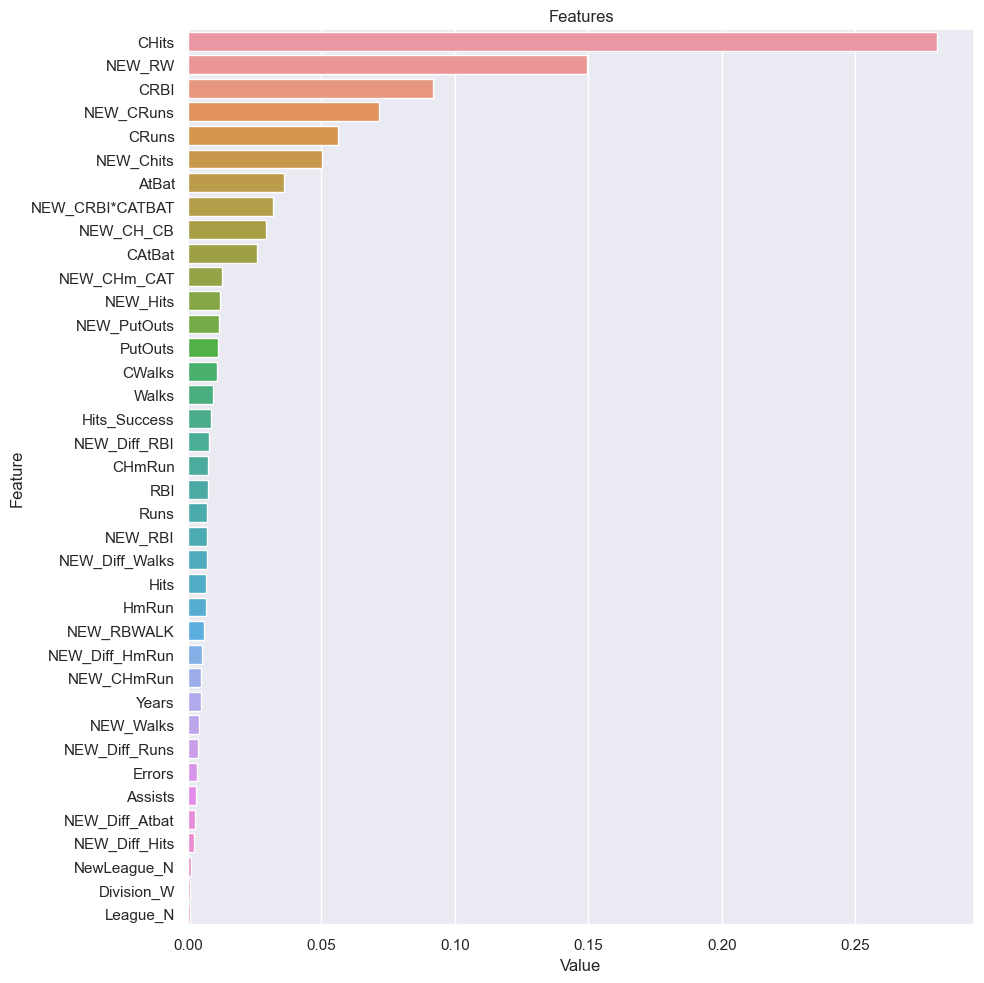

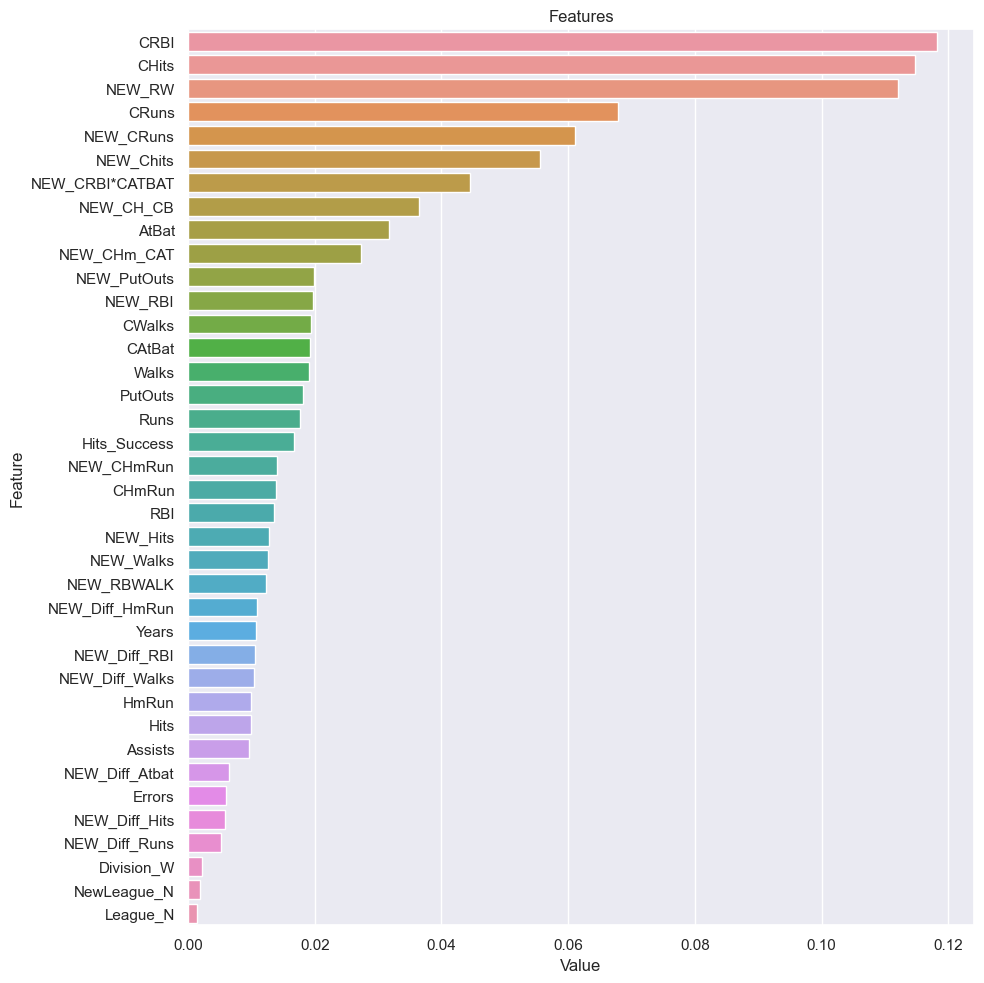

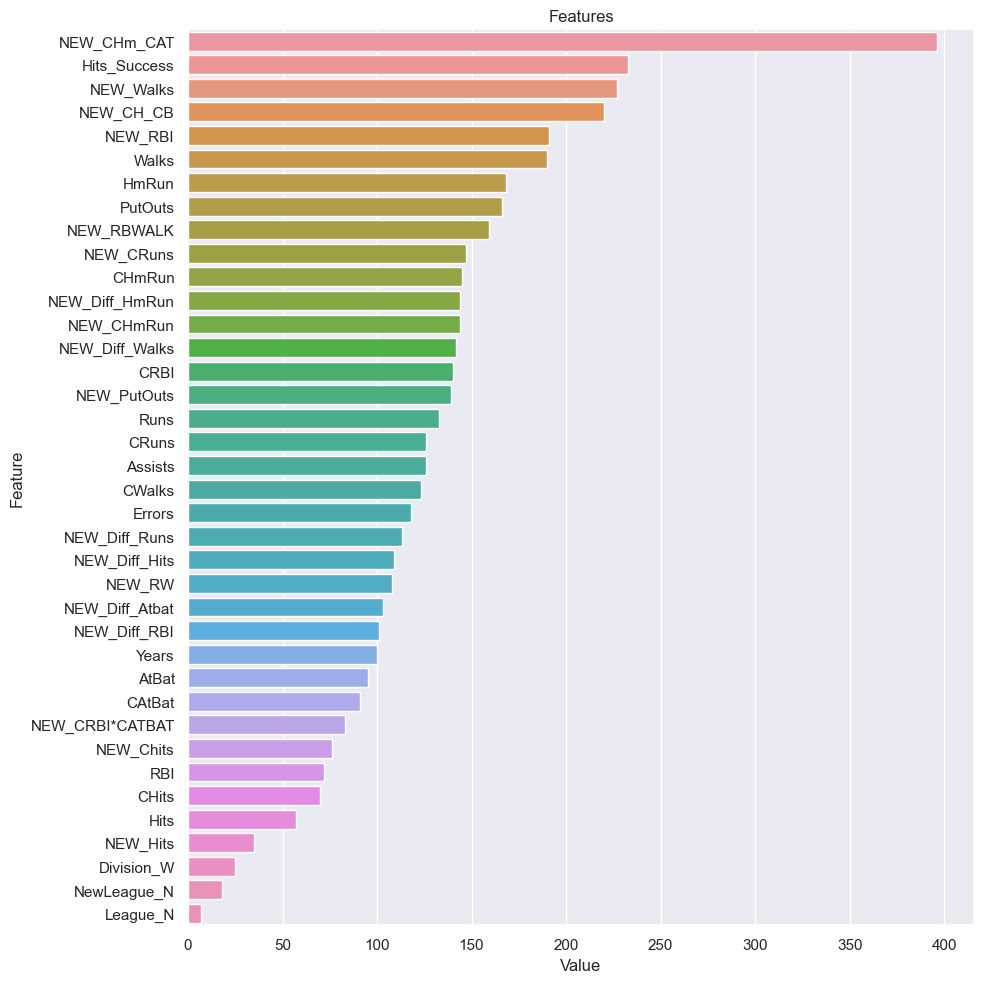

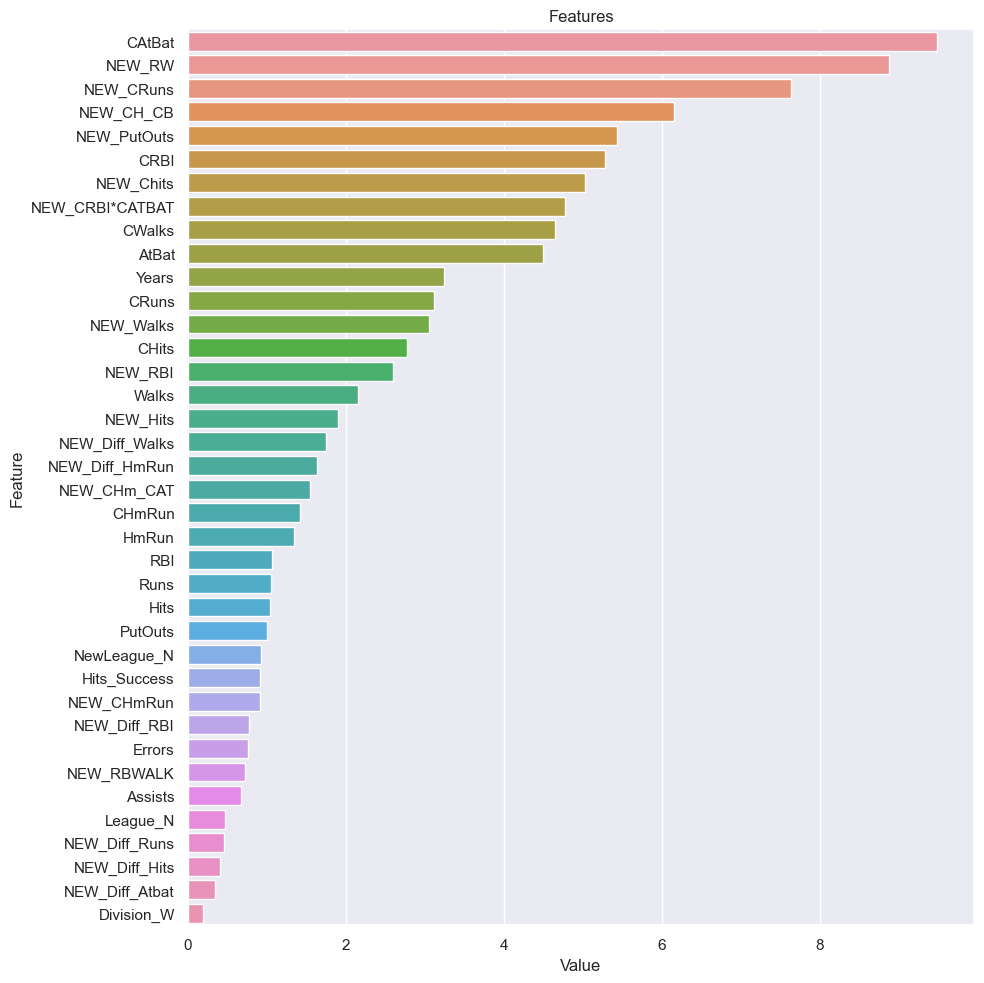

In [26]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(rf_final, X)
plot_importance(gbm_final, X)
plot_importance(lgbm_final, X)
plot_importance(catboost_final, X)


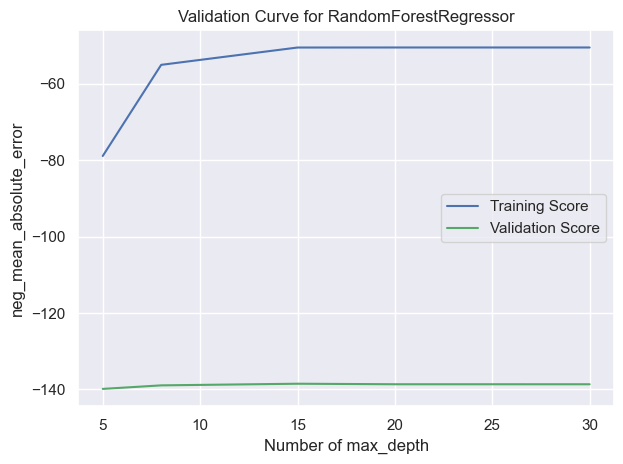

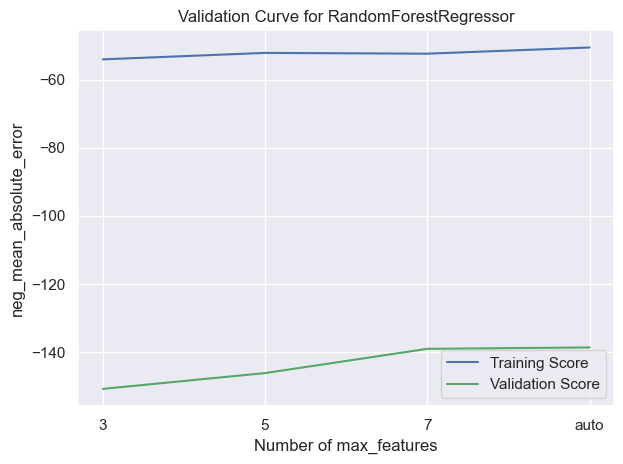

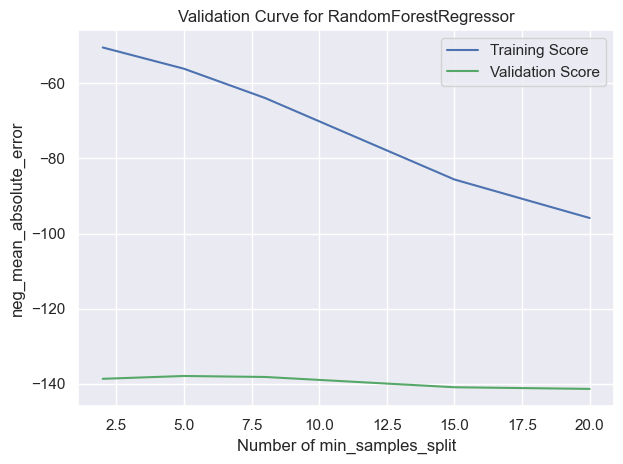

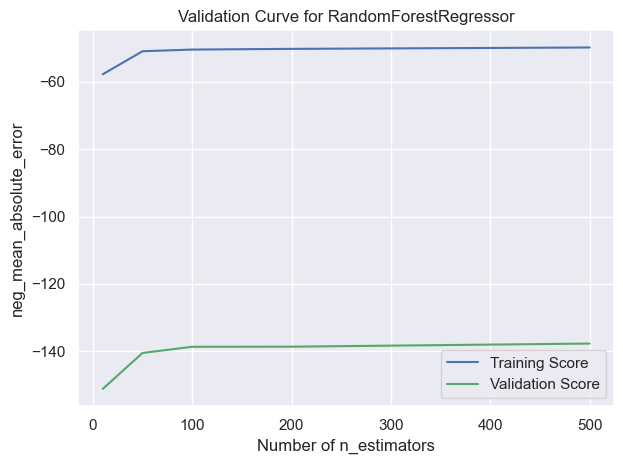

[5, 8, 15, 20, 30, None]

In [27]:
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()


rf_val_params = [["max_depth", [5, 8, 15, 20, 30, None]],
                 ["max_features", [3, 5, 7, "auto"]],
                 ["min_samples_split", [2, 5, 8, 15, 20]],
                 ["n_estimators", [10, 50, 100, 200, 500]]]


rf_model = RandomForestRegressor(random_state=17)

for i in range(len(rf_val_params)):
    val_curve_params(rf_model, X, y, rf_val_params[i][0], rf_val_params[i][1],scoring="neg_mean_absolute_error")

rf_val_params[0][1]